<a href="https://colab.research.google.com/github/Louis0117/Bert/blob/main/Bert_finetune_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download 

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### import package

In [ ]:
from google.colab import drive
import pandas as pd
import torch
from transformers import BertTokenizer
from IPython.display import clear_output 
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

### build model

In [ ]:
# 載入一個可以做中文多分類任務的模型，n_class = 3


PRETRAINED_MODEL_NAME = "bert-large-cased"
NUM_LABELS = 3

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

clear_output()

# high-level 顯示此模型裡的 modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=1024, out_features=3, bias=True)


### 連 google drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 讀檔 / 切分訓練測試集

In [ ]:
AXS_3class = pd.read_csv('/content/drive/MyDrive/XLNet/AXS_dataset_v10/AXS_data_3class_v10.csv',index_col=False)

In [ ]:
train_set, test_set = train_test_split(AXS_3class, random_state=2018, test_size=0.2)

In [ ]:
train_set.reset_index(drop=True,inplace=True)

In [ ]:
test_set.reset_index(drop=True,inplace=True)

### function

In [ ]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    model.eval()  
    with torch.no_grad():
        # 遍巡整個資料集
        for data in dataloader:
            # 將所有 tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            # 用來計算訓練集的分類準確率
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # 將當前 batch 記錄下來
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions
    
# 讓模型跑在 GPU 上並取得訓練集的分類準確率
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
#_, acc = get_predictions(model, trainloader, compute_acc=True)
#print("classification acc:", acc)

device: cuda:0


In [ ]:
class DatasetCreate(Dataset):
    # 讀取前處理後的 tsv 檔並初始化一些參數
    def __init__(self, mode , train_data , test_data , tokenizer):
        self.mode = mode
        if self.mode == 'train':
          self.df = train_data
        elif self.mode == 'test':
          self.df = test_data

        self.len = len(self.df)
        #self.label_map = {'negative': 0, 'positive': 1 }
        self.tokenizer = tokenizer  # 我們將使用 BERT tokenizer

    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == "test":
            text_a = self.df['text'][idx]
            label_tensor = None
        else:
            text_a = self.df['text'][idx]
            label = int(self.df['label'][idx])
            # 將 label 文字也轉換成索引方便轉換成 tensor
            #label_id = self.label_map[label]
            #label_tensor = torch.tensor(label_id)
            label_tensor = torch.tensor(label)

        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a
        #word_pieces += tokens_a + ["[SEP]"]
        len_a = len(word_pieces)
        
        # 第二個句子的 BERT tokens
        #tokens_b = self.tokenizer.tokenize(text_b)
        #word_pieces += tokens_b + ["[SEP]"]
        #len_b = len(word_pieces) - len_a
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        segments_tensor = torch.tensor([0] * len_a , 
                                        dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞
trainset = DatasetCreate('train' , train_set , test_set , tokenizer=tokenizer)

In [ ]:
"""
實作可以一次回傳一個 mini-batch 的 DataLoader
這個 DataLoader 吃我們上面定義的 `FakeNewsDataset`，
回傳訓練 BERT 時會需要的 4 個 tensors：
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""

# 這個函式的輸入 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    

    # zero pad 到同一序列長度
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 64 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

### train model

In [ ]:
loss_record = []

#%%time

# 訓練模式
model.train()

# 使用 Adam Optim 更新整個分類模型的參數
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


EPOCHS = 40  # 幸運數字
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for data in trainloader:
        
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()

        loss_record.append(loss.item())
        # 紀錄當前 batch loss
        running_loss += loss.item()
        
        
    # 計算分類準確率
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))

[epoch 1] loss: 99.569, acc: 0.613
[epoch 2] loss: 88.312, acc: 0.781
[epoch 3] loss: 62.451, acc: 0.853
[epoch 4] loss: 41.337, acc: 0.953
[epoch 5] loss: 21.320, acc: 0.973
[epoch 6] loss: 10.265, acc: 0.984
[epoch 7] loss: 9.501, acc: 0.989
[epoch 8] loss: 6.976, acc: 0.990
[epoch 9] loss: 3.711, acc: 0.991
[epoch 10] loss: 4.530, acc: 0.990
[epoch 11] loss: 4.032, acc: 0.999
[epoch 12] loss: 1.607, acc: 0.998
[epoch 13] loss: 1.124, acc: 0.999
[epoch 14] loss: 0.732, acc: 0.999
[epoch 15] loss: 0.406, acc: 0.999
[epoch 16] loss: 0.405, acc: 0.999
[epoch 17] loss: 0.339, acc: 1.000
[epoch 18] loss: 0.289, acc: 1.000
[epoch 19] loss: 0.241, acc: 1.000
[epoch 20] loss: 0.170, acc: 1.000
[epoch 21] loss: 0.034, acc: 1.000
[epoch 22] loss: 0.020, acc: 1.000
[epoch 23] loss: 0.015, acc: 1.000
[epoch 24] loss: 0.013, acc: 1.000
[epoch 25] loss: 0.012, acc: 1.000
[epoch 26] loss: 0.010, acc: 1.000
[epoch 27] loss: 0.009, acc: 1.000
[epoch 28] loss: 0.009, acc: 1.000
[epoch 29] loss: 0.008,

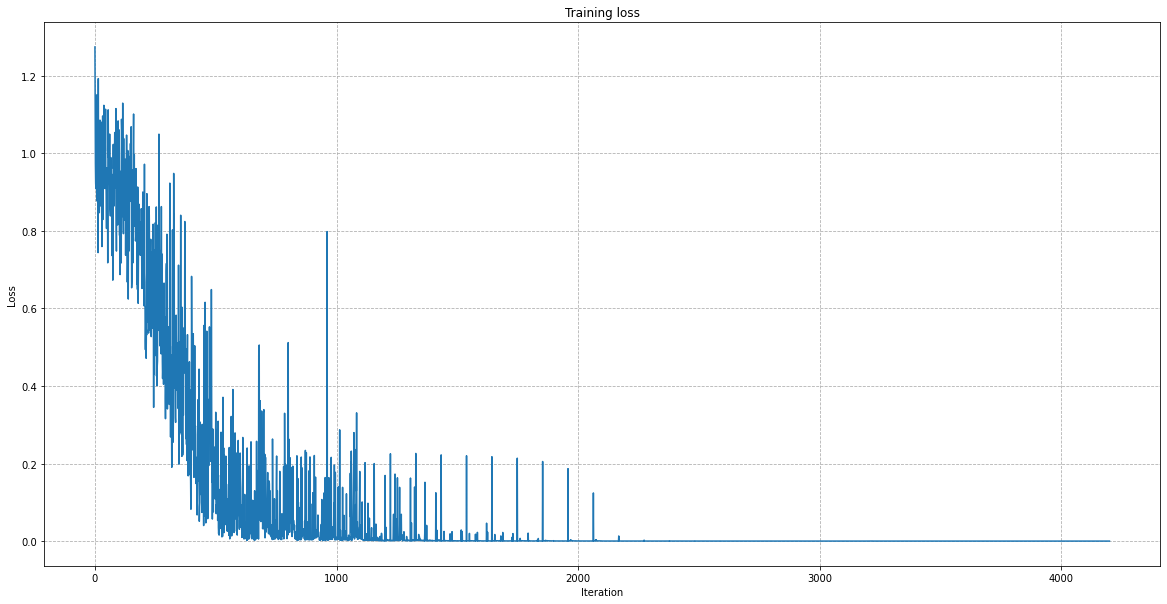

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Training loss")
plt.xlabel("lteration")
plt.ylabel("Loss")
plt.plot(loss_record)
plt.grid(ls='--')
plt.show()

### testing

In [ ]:
testset = DatasetCreate('test' , train_set , test_set , tokenizer=tokenizer)

testloader = DataLoader(testset, batch_size=32, 
                        collate_fn=create_mini_batch)

predictions = get_predictions(model , testloader)

In [ ]:
predictions

tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2,
        0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0,
        0, 0, 2, 0, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2,
        0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2,
        2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2,
        0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0,
        2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [ ]:
predictions = np.array(predictions.cpu())

In [ ]:
predictions

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0,
       0, 2, 0, 0, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0,

In [ ]:
label = np.array(test_set['label'])

In [ ]:
predictions.shape

(836,)

In [ ]:
micro_f1score = f1_score(label, predictions, average='micro')
macro_f1score = f1_score(label, predictions, average='macro')
#f1score3 = f1_score(actual, predicted, average='weighted')
confusion_matrix = confusion_matrix(label, predictions)

micro f1-score

In [ ]:
micro_f1score

0.7416267942583733

macro f1-score

In [ ]:
macro_f1score

0.6825871885881373

confusion matrix

In [ ]:
confusion_matrix

array([[430,  22,  44],
       [ 74,  77,  10],
       [ 63,   3, 113]])

### reference
https://leemeng.tw/attack_on_bert_transfer_learning_in_nlp.html